# Imports

In [1]:
import pandas as pd
import numpy as np
import scipy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.spatial.distance import cosine
from scipy.sparse import hstack, vstack
import matplotlib.pyplot as plt
from utils import compute_confusion_matrix, compute_scores

# Data loading

In [2]:
train_df = pd.read_csv("../data/train.csv").fillna("")
test_df = pd.read_csv("../data/test.csv").fillna("")

In [3]:
train_df.sample()

,q1_id,q2_id,q1_text,q2_text,is_duplicate
185080,505950,505951,Are there any good health benefits by eating f...,What are the benefits of fast food?,1


# TF-IDF

TF-IDF stands for **Term Frequency-Inverse Document Frequency**. This term is used as a feature for the model. 

It is a measure that can quantify the importance or relevance of string representations (words, phrases, lemmas, etc) in a document amongst a collection of documents (also known as a corpus).

**TF**

Term frequency works by looking at the frequency of a particular term you are concerned with relative to the document. There are multiple measures, or ways, of defining frequency:

- Number of times the word appears in a document (raw count).
- Term frequency adjusted for the length of the document (raw count of occurences divided by number of words in the document).
- Logarithmically scaled frequency (e.g. log(1 + raw count)).
- Boolean frequency (e.g. 1 if the term occurs, or 0 if the term does not occur, in the document).

**IDF**

Inverse document frequency looks at how common (or uncommon) a word is amongst the corpus. IDF is calculated as follows where **t** is the term (word) we are looking to measure the commonness of and **N** is the number of documents (d) in the corpus (D).. The denominator is simply the number of documents in which the term, t, appears in. 

- $idf(t,D) = log(\frac{N}{(count(d\in D:t\in d)})$

The reason we need IDF is to help correct for words like “of”, “as”, “the”, etc. since they appear frequently in an English corpus. Thus by taking inverse document frequency, we can minimize the weighting of frequent terms while making infrequent terms have a higher impact.

In our use case, we can consider the corpus as the set of sentences and each sentences as a document. 

To summarize the key intuition motivating TF-IDF is the importance of a term is inversely related to its frequency across sentences.TF gives us information on how often a term appears in a sentence and IDF gives us information about the relative rarity of a term in the collection of sentences. By multiplying these values together we can get our final TF-IDF value.

Therfore **TF-IDF** : 

$ tf.idf = count(t \in d).log(\frac{N}{(count(d\in D:t\in d)})$

The higher the TF-IDF score the more important or relevant the term is; as a term gets less relevant, its TF-IDF score will approach 0.

In [4]:
vectorizer = TfidfVectorizer()

In [5]:
vectorizer.fit(pd.concat([train_df["q1_text"], train_df["q2_text"]]))

TfidfVectorizer()

In [6]:
def create_features(df: pd.DataFrame, vectorizer: TfidfVectorizer) -> pd.DataFrame:
    q1_vec = vectorizer.transform(df["q1_text"])
    q2_vec = vectorizer.transform(df["q2_text"])
    return q1_vec, q2_vec

In [7]:
def cos_sim(a, b):
    return cosine_similarity(a, b)[0][0]

In [8]:
q1_vec, q2_vec = create_features(train_df, vectorizer)

In [9]:
q1_vec

<202145x63449 sparse matrix of type '<class 'numpy.float64'>'
	with 2014678 stored elements in Compressed Sparse Row format>

In [11]:
print(train_df.shape)
print(q1_vec.shape)
print(q2_vec.shape)

(202145, 5)
(202145, 63449)
(202145, 63449)


We have a sparse matrix with shape **(202 145 x 63 449)** : 

- 202 145 lines for all the sentences we have in train_df
- 63 449 columns for all the words present in all the sentences, applying tf-idf, we get the score of each word if it is present in the given sentence, 0 otherwise. 

This is the reason why we get a sparse matrix, that contains a lot of 0 in it. 

If we **stack the two vectors into a single vector to train the model**, we will get the exact same number of lines (202 145) and much more features (the sum of the two vectors) which correspond to 126 898 features:

### Cosine distance :  to check similarity bewteen the questions 

Cosine similarity is a metric used to measure how similar the sentences are, irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space.

The cosine similarity is advantageous because even if the two similar sentences are far apart by the Euclidean distance (due to **the size of the sentence**), chances are they may still be oriented closer together. The smaller the angle, higher the cosine similarity.

#### Quick explanation, why the euclidean is not appropriate for sentences similarity : 

- Euclidean distance : 

$\sqrt{\sum^{n}_{1}\left(x_{i}-y_{i}\right)^{2}}$

- Cosine distance : 

$sim(X,Y) = cos(\theta_{X,Y}) = \frac{X.Y}{\left\|X\right\|.\left\|Y\right\|}$

If we take this example 👇 and compute euclidean distance on these sentences : 
- text_1 = "I love playing football with my friends"
- text_2 = "I hate waching and playing basketball"
- text_3 = "When I was a kid I was playing football with my friends every day all the evening"

We get those results : 

|/|Text_1|Text_2|Text_3|
|------|------|------|------|
|text_1|0.000000|3.000000|3.464102|
|text_2| 3.000000|0.000000|4.358899|
|text_3| 3.464102|4.358899|0.000000|

In this case, the result is not what we expected. The above table presents text 1 to be similar to text 2, which is not pragmatic. As to the meaning of the above sentences, text 1 is similar to text 3. So, there is a factor that spoils the result and affects the Euclidian metric.

As you may have figured out by observing the sentences, the length of the text is a factor that affects the result. Long sentences tend to have higher Euclideum score than the short ones.


If you want to learn more about these two metrics, cosine and euclidean, you can read [this blog](https://nikoskalikis.medium.com/text-similarity-euclidian-distance-vs-cosine-similarity-3a1167f686a) 


#### Therefore we will use the cosinus similarity as a new feature for the model 

Applying the map function on all the matrix : 

In [15]:
%%time 
result_map = map(cos_sim, q1_vec, q2_vec)
cos_sim_result = list(result_map)

CPU times: user 1min 44s, sys: 478 ms, total: 1min 44s
Wall time: 1min 45s


In [16]:
# List of the scores of all the question pairs
cos_sim_result[:15]

[0.4311616458185753,
 0.27359613477909395,
 0.15679509174514905,
 0.707137677198991,
 0.7820547113664686,
 0.565373159566199,
 0.7734070180588744,
 0.5942380623294409,
 0.6297092522122608,
 0.6975264610783164,
 0.7063299029651017,
 0.8536878814491092,
 0.22270695021032982,
 0.4088166569351638,
 0.013725237260734354]

👇 Below an example of a pair of similar questions, we observe how the cosine-similarity function behaves, what is its score? Does it consider that the two questions are similar? What is the value of the score? 

In [17]:
idx = 9

print(q1_vec[idx] @ q2_vec[idx].T)

  (0, 0)	0.6975264610783163


In [18]:
print(train_df["q1_text"].iloc[idx])
print(train_df["q2_text"].iloc[idx])
print(f"\n-> Are they duplicates ? {'Yes' if (train_df['is_duplicate'].iloc[idx]) == 1 else 'No'}\n")

print(f"Scores results : \n- {cos_sim(q1_vec[idx],q2_vec[idx])}\n")

print(f"If we apply the formula X.Y we get :{(q1_vec[idx] @ q2_vec[idx].T)[0,0]} since ||X|| = ||Y|| = 1")

How can I learn baking like a pro in Delhi?
What is the best way to learn baking in Delhi?

-> Are they duplicates ? Yes

Scores results : 
- 0.6975264610783164

If we apply the formula X.Y we get :0.6975264610783163 since ||X|| = ||Y|| = 1


### Matrix calulations vectorized

#### 👇 Below we test different approaches of optimized matrix calculations

In [19]:
%%time
q1_vec.multiply(q2_vec).sum(axis=1)

CPU times: user 77.5 ms, sys: 15.4 ms, total: 92.9 ms
Wall time: 91.7 ms


matrix([[0.43116165],
        [0.27359613],
        [0.15679509],
        ...,
        [0.37552765],
        [0.6525128 ],
        [0.43336309]])

👉 These results are exactly the same as the ones we get using the cosine similarity function. The only difference in these methods is the calculation time. Matrix calculations are optimized by using the numpy array. For the matrix calculation, it took 448 ms against 1min 43s for the cosine similarity

In [29]:
%%time
cos_score = []
for (a,b) in zip(q1_vec, q2_vec):
    cos_score.append(np.dot(a, b.T))
print(cos_score[0][0])

  (0, 0)	0.4311616458185753
CPU times: user 1min 8s, sys: 1.02 s, total: 1min 9s
Wall time: 1min 10s


$$
    similarity(i) = \sum\limits_{j=1}\limits^{n}{a_{i,j} b_{i,j}}
$$

#### Euclidean distance vectorized, to accelerate the computation : 

In [31]:
np.sqrt(
    np.array(
        (q1_vec - q2_vec).multiply(q1_vec - q2_vec).sum(axis=1)
    )
)

array([[1.06661929],
       [1.20532474],
       [1.29861843],
       ...,
       [1.11756194],
       [0.83365124],
       [1.06455334]])

In [23]:
def rowwise_cosine_similarity(a: scipy.sparse._csr.csr_matrix, b: scipy.sparse._csr.csr_matrix) -> np.ndarray:
    return np.array(a.multiply(b).sum(axis=1))[:, 0]

In [24]:
def rowwise_euclidian_distance(a: scipy.sparse._csr.csr_matrix, b: scipy.sparse._csr.csr_matrix) -> np.ndarray:
    return np.sqrt(np.array((q1_vec - q2_vec).power(2).sum(axis=1)))[:, 0]

In [27]:
def relative_length_diff(df: pd.DataFrame) -> pd.Series:
    q1_nb_words = df["q1_text"].str.split().str.len()
    q2_nb_words = df["q2_text"].str.split().str.len()
    max_length = pd.concat([q1_nb_words, q2_nb_words], axis=1).max(axis=1)
    length_diff = (q1_nb_words - q2_nb_words).abs()
    return length_diff / max_length

def common_words_ratio(df: pd.DataFrame) -> pd.Series:
    q1_words = df["q1_text"].str.split().map(set)
    q2_words = df["q2_text"].str.split().map(set)
    common_words_ratio = pd.DataFrame({"q1_words": q1_words, "q2_words": q2_words}).apply(
        lambda row: len(row["q1_words"].intersection(row["q2_words"])) / len(row["q1_words"].union(row["q2_words"])),
        axis=1
    )
    return common_words_ratio

def word_present_in_both(word: str, df: pd.DataFrame) -> pd.Series:
    return (
        df["q1_text"].str.lower().str.contains(word) & 
        df["q2_text"].str.lower().str.contains(word)
    ).astype(int)

In [28]:
def create_features(df: pd.DataFrame, vectorizer: TfidfVectorizer) -> pd.DataFrame:
    q1_vec = vectorizer.transform(df["q1_text"])
    q2_vec = vectorizer.transform(df["q2_text"])
    return pd.DataFrame({
        "cosine_similarity": rowwise_cosine_similarity(q1_vec, q2_vec),
        "common_words_ratio": common_words_ratio(df),
        "how_in_both": word_present_in_both("how", df),
        "how_many_in_both": word_present_in_both("how many", df),
        "how_much_in_both": word_present_in_both("how much", df),
        "why_in_both": word_present_in_both("why", df),
        "when_in_both": word_present_in_both("when", df),
        "who_in_both": word_present_in_both("who", df),
        "what_in_both": word_present_in_both("what", df)
    })

In [29]:
features = {
    "train": create_features(train_df, vectorizer),
    "test": create_features(test_df, vectorizer)
}

targets = {
    "train": train_df["is_duplicate"],
    "test": test_df["is_duplicate"]
}

In [30]:
model = DecisionTreeClassifier(max_depth=6, class_weight={0: 1, 1: 1.5})

model.fit(features["train"].fillna(0.), targets["train"])

DecisionTreeClassifier(class_weight={0: 1, 1: 1.5}, max_depth=6)

In [31]:
y_test_true = targets["test"]
y_test_pred = model.predict(features["test"].fillna(0))

In [32]:
compute_scores(y_test_true, y_test_pred)

{'Accuracy': '69.28%', 'Recall': '84.95%', 'Precision': '55.48%'}

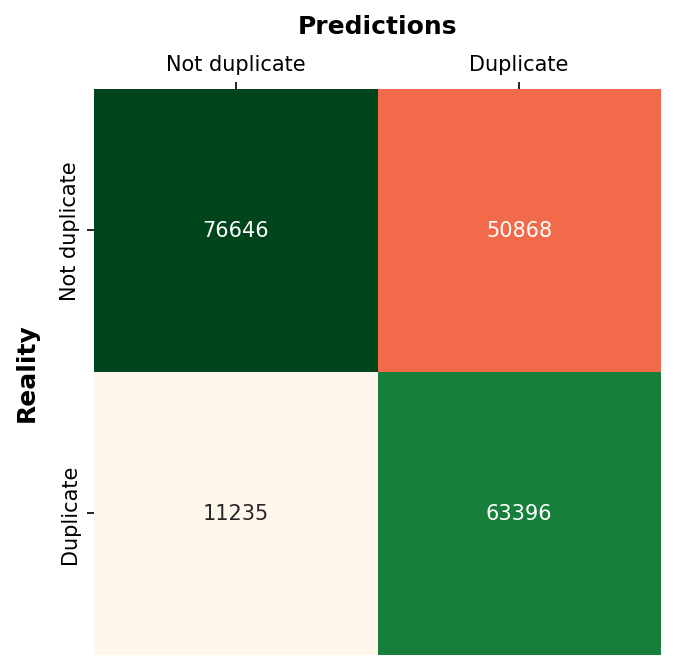

In [33]:
compute_confusion_matrix(y_test_true, y_test_pred, dpi=150)

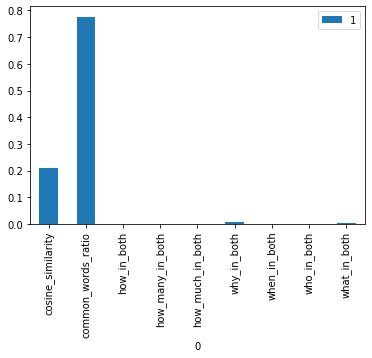

In [34]:
pd.DataFrame(
    list(
        zip(
            model.feature_names_in_,
            model.feature_importances_
        )
    )
).plot.bar(x=0, y=1)

plt.show()